<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://bsethwalker.github.io/assets/img/clemson_paw.png"> </div>


## Week 5: Dimensionality Reduction

**Clemson University**<br>
**Spring 2022**<br>
**Instructor(s):** Nina Hubig <br>
**Author(s):** Chris Kalahiki, Brandon Walker


---

In [16]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://bsethwalker.github.io/assets/css/cpsc6300.css").text
HTML(styles)

## Learning Goals
In this lab, we will look at how to use PCA to reduce a dataset to a smaller number of dimensions. The goal is for students to:
<ul>
  <li>Understand what PCA is and why it's useful</li>
  <li>Feel comfortable performing PCA on a new dataset</li>
  <li>Understand what it means for each component to capture variance from the original dataset</li>
  <li>Be able to extract the `variance explained` by components.</li>
  <li>Perform modelling with the PCA components</li>
</ul>  

In [17]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.linalg import svd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn.model_selection import train_test_split

## Part 1-1:  Introduction to PCA

What is PCA? PCA is a deterministic technique to transform data to a lowered dimensionality, whereby each feature/dimension captures the most variance possible.

Why do we care to use it?
<ul>
  <li>Visualizating the components can be useful</li>
  <li>Allows for more efficient use of resources (time, memory)</li>
  <li>Statistical reasons: fewer dimensions -> better generalization</li>
  <li>noise removal / collinearity (improving data quality)</li>
</ul>  

Imagine some dataset where we have two features that are pretty redundant. For example, maybe we have data concerning elite runners. Two of the features may include ``VO2 max`` and ``heartrate``. These are highly correlated. We probably don't need both, as they don't offer much additional information from each other. Using a [great visual example from online](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues), let's say that this unlabelled graph **(always label your axis)** represents those two features:

![VO2 Max vs Heart Rate](assets/original_data.png)

Let's say that this is our entire dataset, just 2 dimensions. If we wish to reduce the dimensions, we can only reduce it to just 1 dimension. A straight line is just 1 dimension (to help clarify this: imagine your straight line as being the x-axis, and values can be somewhere on this axis, but that's it. There is no y-axis dimension for a straight line). So, how should PCA select a straight line through this data?

Below, the image shows all possible projects that are centered in the data:

![Animation of possible lines](assets/animation.gif)

PCA picks the line that:
<ul>
<li>captures the most variance possible</li>
<li>minimizes the distance of the transformed points (distance from the original to the new space)</li>
</ul>

The animation **suggests** that these two aspects are actually the same. In fact, this is objectively true, but the proof for which is beyond the scope of the material for now. Feel free to read more at [this explanation](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m/136072#136072) and via [Andrew Ng's notes](http://cs229.stanford.edu/notes/cs229-notes-all/cs229-notes10.pdf).

In short, PCA is a math technique that works with the covariance matrix -- the matrix that describes how all pairwise features are correlated with one another. Covariance of two variables measures the degree to which they moved/vary in the same directin; how much one variable affects the other. A positive covariance means they are positively related (i.e., x1 increases as x2 does); negative means negative correlation (x1 decreases as x2 increases).

In data science and machine learning, our models are often just finding patterns in the data this is easier if the data is spread out across each dimension and for the data features to be independent from one another (imagine if there's no variance at all. We couldn't do anything). Can we transform the data into a new set that is a linear combination of those original features?

PCA finds new dimensions (set of basis vectors) such that all the dimensions are orthogonal and hence linearly independent, and ranked according to the variance (eigenvalue). That is, the first component is the most important, as it captures the most variance.

## Part 1-2:  The Wine Dataset

Imagine that a wine sommelier has tasted and rated 1,000 distinct wines, and now that she's highly experienced, she is curious if she can more efficiently rate wines without even trying them. That is, perhaps her tasting preferences follow a pattern, allowing her to predict the rating a new wine without even trying it!  

The dataset contains 11 chemical features, along with a quality scale from 1-10; however, only values of 3-9 are actually used in the data. The ever-elusive perfect wine has yet to be tasted. 

#### **NOTE:** While this dataset involves the topic of alcohol, we, along with Clemson at large is in no way encouraging alcohol use, and this example should not be intrepreted as any endorsement for such; it is merely a pedagogical example. I apologize if this example offends anyone or is off-putting.



### Read-in and checking
First, let's read-in the data and verify it:

In [18]:
wines_df = pd.read_csv("data/wines.csv")
wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [19]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


For this exercise, let's say that the wine expert is curious if she can predict, as a rough approximation, the **categorical quality -- bad, average, or great.** Let's define those categories as follows:

- `bad` is when for wines that have a quality <= 5
- `average` is when a wine has a quality of 6 or 7
- `great` is when a wine has a quality of >= 8

In [20]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to the aforementioned bins (inclusive boundaries)
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,5,7,10], labels=[0,1,2])
wines_df_recode.loc[wines_df_recode['quality'] == 1]

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality'], axis=1)
y_data = wines_df_recode['quality']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

# previews our data to check if we correctly constructed the labels (we did)
print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64
0    0
1    0
2    0
3    1
4    0
Name: quality, dtype: category
Categories (3, int64): [0 < 1 < 2]


For sanity, let's see how many wines are in each category:

In [21]:
y_data.value_counts()


1    3915
0    2384
2     198
Name: quality, dtype: int64

Now that we've split the data, let's look to see if there are any obvious patterns (correlations between different variables).

array([[<AxesSubplot:xlabel='fixed acidity', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='volatile acidity', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='citric acid', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='residual sugar', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='chlorides', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='free sulfur dioxide', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='total sulfur dioxide', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='density', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='pH', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='sulphates', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='alcohol', ylabel='fixed acidity'>,
        <AxesSubplot:xlabel='red', ylabel='fixed acidity'>],
       [<AxesSubplot:xlabel='fixed acidity', ylabel='volatile acidity'>,
        <AxesSubplot:xlabel='volatile acidity', ylabel='volatile acidity'>,
        <AxesSubplot:xlabel='citric 

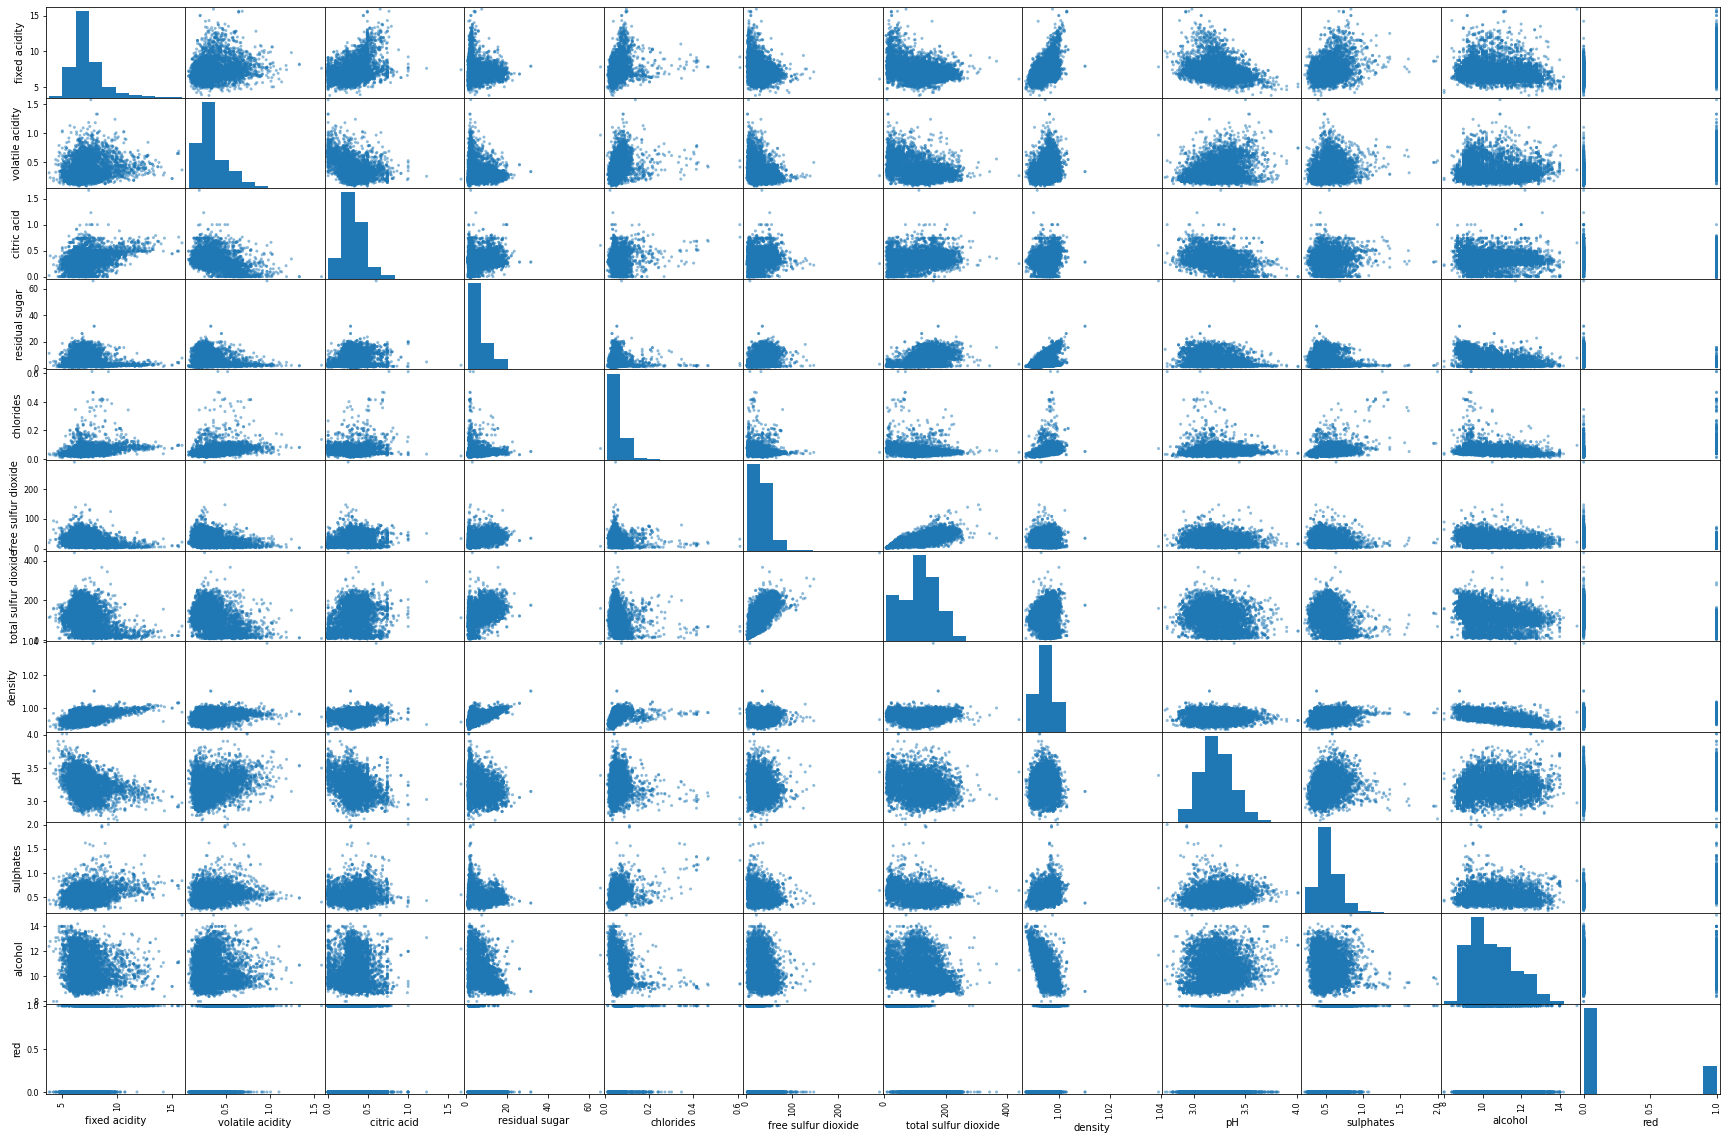

In [22]:
from pandas.plotting import scatter_matrix
scatter_matrix(wines_df_recode, figsize=(30,20))

It looks like there aren't any particularly strong correlations among the predictors (maybe `total sulfur dioxide` and `free sulfur dioxide`) so we're safe to keep them all.

## Part 1-3: Prediction Models
Before we do anything too fancy, it's always best to start with something simple.

### MLE Baseline
Maximum-likelihood estimate is barely a model -- it simple returns the single label/class that maximizes the likelihood that the training data was observed. In other words, whichever label/class is most popular, it will always emit that as its answer, completely independent of any x-data. Above, we saw that the most popular label was `average`, represented by 598 of our 1,000 wines. Thus, our MLE should yield `average` for all inputs:

In [23]:
mle_class = y_data.value_counts().idxmax()
mle_train_accuracy = len(y_train.loc[y_train == mle_class]) / len(y_train)
mle_test_accuracy = len(y_test.loc[y_test == mle_class]) / len(y_test)

# add it to a new dataframe of results
#model_results = {'MLE': [mle_train_accuracy, mle_test_accuracy]}

scores = [[mle_train_accuracy, mle_test_accuracy]]
names = ['MLE']
df_results = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
MLE,0.602655,0.602308


MLE gives a predictive accuracy is **60.0%** on the test set. Hopefully we can do better than this.

### Logistic Regression
Logistic regression is used for predicting categorical outputs, which is exactly what our task concerns. So, let's create a logistic regression model:

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train,y_train)
print("Coefficients:", lr.coef_)
print("Intercepts:", lr.intercept_)

Coefficients: [[-5.08306522e-03  4.69278588e+00  4.12563106e-01 -6.66372448e-02
   1.91857951e+00 -1.53290878e-02  5.98904889e-03  4.86528817e+00
  -3.59539627e-01 -1.80836571e+00 -9.46083758e-01 -3.50351926e-01]
 [ 2.73983793e-02 -4.38720806e+00 -5.38219578e-01  4.93591022e-02
  -1.64034200e+00  1.05671469e-02 -4.91662003e-03 -3.65647553e+00
   4.18655163e-01  1.59471468e+00  6.75662800e-01  3.00807983e-01]
 [ 4.27582406e-02 -1.72664859e+00  7.62738143e-01  9.40092585e-02
  -2.56775612e+00  2.27501893e-02 -7.62881119e-03 -8.63445587e+00
   1.06567390e+00  3.60833690e-01  9.03004879e-01 -7.64272202e-01]]
Intercepts: [ 4.88829162 -3.68150352 -8.6455888 ]


<div class="exercise"><b>Exercise:</b> What is stored in `.coef_` and `.intercept_`? Why are there so many of them?</div>


In short, it's because there are N models, where N is our number of class labels (due to running logistic regression in a one-vs-rest manner).

Let's measure its performance:

In [25]:
lr_train_accuracy = lr.score(x_train, y_train)
lr_test_accuracy = lr.score(x_test, y_test)

# appends results to our dataframe
names.append('Logistic Regression')
scores.append([lr_train_accuracy, lr_test_accuracy])
df_results = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
MLE,0.602655,0.602308
Logistic Regression,0.715605,0.713846


Yay, that's better than our MLE's performance. Can we do better with cross-validation?

#### Summary
- Logistic regression extends OLS to work naturally with a dependent variable that's only ever 0 and 1.
- In fact, Logistic regression is even more general and is used for predicting the probability of an example belonging to each of $N$ classes.
- The code for the two cases is identical and just like `LinearRegression`: `.fit`, `.score`, and all the rest
- Significant predictors does not imply that the model actually works well. Signifigance can be driven by data size alone.
- The data aren't enough to do what we want

**Warning**: Logistic regression _tries_ to hand back valid probabilities. As with all models, you can't trust the results until you validate them- if you're going to use raw probabilities instead of just predicted class, take the time to verify that if you pool all cases where the model says "I'm 30% confident it's class A" 30% of them actually are class A.

In [26]:
logit_regr_lasso = LogisticRegressionCV(solver='liblinear', multi_class='ovr', penalty='l1', max_iter=100000, cv=10)
logit_regr_lasso.fit(x_train,y_train) # fit

y_train_pred_lasso = logit_regr_lasso.predict(x_train) # predict the test set
y_test_pred_lasso = logit_regr_lasso.predict(x_test) # predict the test set

train_score_lasso = accuracy_score(y_train, y_train_pred_lasso) # get train accuracy
test_score_lasso = accuracy_score(y_test, y_test_pred_lasso) # get test accuracy

names.append('Logistic Regression w/ CV + Lasso')
scores.append([train_score_lasso, test_score_lasso])
df_results = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
MLE,0.602655,0.602308
Logistic Regression,0.715605,0.713846
Logistic Regression w/ CV + Lasso,0.714643,0.713846


<div class="exercise"><b>Exercise:</b> Hmm, cross-validation didn't seem to offer improved results. Is this correct? Is it possible for cross-validation to not yield better results than non-cross-validation? If so, how and why?</div>


In [27]:
# answer was discussed in lab

## Part 1-4: Dimensionality Reduction
In attempt to improve performance, we may wonder if some of our features are redundant and are posing difficulties for our logistic regression model. Let's PCA to shrink the problem down to 2 dimensions (with as little loss as possible) and see if that gives us a clue about what makes this problem tough.

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 2

# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)

# reduce dimensions
pca_transformer = PCA(num_components).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

print(x_train_2d.shape)
x_train_2d[0:5,:]

(5197, 2)


array([[-0.70269209, -1.29478807],
       [-1.95370693,  2.95246548],
       [-1.78457056,  0.85532164],
       [-1.24564712,  0.66718074],
       [-1.79701612, -1.2306774 ]])

**NOTE:**
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform() to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying PCA; otherwise, certain dimensions will dominate the scaling. Our PCA dimensions would just be the features with the largest spread.

<div class="exercise"><b>Exercise:</b> Why didn't we scale the y-values (class labels) or transform them with PCA? Is this a mistake?</div>


In [29]:
# answer was discussed in lab

<div class="exercise"><b>Exercise:</b> Our data only has 2 dimensions/features now. What do these features represent?</div>

In [30]:
# answer heavily discussed in lab

Since our data only has 2 dimensions now, we can easily visualize the entire dataset. If we choose to color each datum with respect to its associated label/class, it allows us to see how separable the data is. That is, it gives an indication as to how easy/difficult it is for a model to fit the new, transformed data.

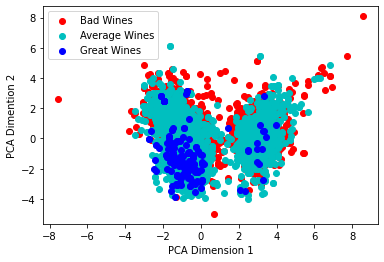

In [31]:
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Bad Wines", "Average Wines", "Great Wines"]

# and we loop over the different groups
for cur_quality in [0,1,2]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend()

Well, that gives us some idea of why the problem is difficult! The bad, average, and great wines are all on top of one another. Not only are there few great wines, which we knew from the beginning, but there is no line that can easily separate the classes of wines.

<div class="exercise"><b>Exercise:</b></div>

<ol>
  <li>What critique can you make against the plot above? Why does this plot not prove that the different wines are hopelessly similar?</li>
  <li>The wine data we've used so far consist entirely of continuous predictors. Would PCA work with categorical data?</li>
</ol>

In [32]:
# answer was discussed in lab

Looking at our PCA plot above, we see something peculiar: we have two disjoint clusters, both of which have immense overlap in the qualities of wines.

<div class="exercise"><b>Exercise:</b> What could cause this? What does this mean?</div>

In [33]:
# answer was discussed in lab

Let's plot the same PCA'd data, but let's color code them according to if the wine is red or white

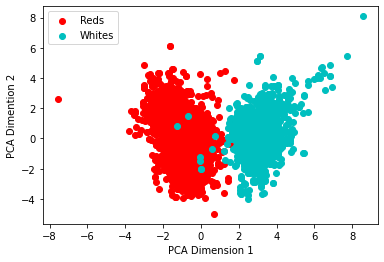

In [34]:
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Reds", "Whites"]

# and we loop over the different groups
for cur_color in [0,1]:
    cur_df = x_train_2d[x_train['red']==cur_color]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_color], label=label_text[cur_color])
    
# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend()

<div class="exercise"><b>Exercise:</b> Wow. Look at that separation. Too bad we aren't trying to predict if a wine is red or white. Does this graph help you answer our previous question? Does it change your thoughts?</div>


In [35]:
# answer was discussed in lab

## 1-5. Evaluating PCA: Variance Explained and Predictions
One of the criticisms we made of the PCA plot was that it's lost something from the original data. Heck, we're only using 2 dimensions, we it's perfectly reasonable and expected for us to lose some information -- our goal was that the information we were discarding was noise.

Let's investigate how much of the original data's structure the 2-D PCA captures. We'll look at the `explained_variance_ratio_` portion of the PCA fit. This lists, in order, the percentage of the x data's total variance that is captured by the nth PCA dimension.

In [36]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

Variance explained by each PCA component: [0.31657619 0.21142542]
Total Variance Explained: 0.5280016077339852


The first PCA dimension captures 33% of the variance in the data, and the second PCA dimension adds another 20%. Together, we've captured about half of the total variation in the training data with just these two dimensions. So far, we've used PCA to transform our data, we've visualized our newly transformed data, and we've looked at the variance that it captures from the original dataset. That's a good amount of inspection; now let's actually use our transformed data to make predictions.

<br>

<div class="exercise"><b>Exercise:</b> Use Logistic Regression (with and without cross-validation) on the PCA-transformed data. Do you expect this to outperform our original 75% accuracy? What are your results? Does this seem reasonable?</div>

In [37]:
# partial solution provided (not showing CV portion)
lr = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(x_train_2d,y_train)

lr_pca_train_accuracy = lr.score(x_train_2d, y_train)
lr_pca_test_accuracy = lr.score(x_test_2d, y_test)

names.append('Logistic Regression w/ PCA')
scores.append([lr_pca_train_accuracy, lr_pca_test_accuracy])
df_results = pd.DataFrame(scores, index=names, columns=['Train Accuracy', 'Test Accuracy'])
df_results

,Train Accuracy,Test Accuracy
MLE,0.602655,0.602308
Logistic Regression,0.715605,0.713846
Logistic Regression w/ CV + Lasso,0.714643,0.713846
Logistic Regression w/ PCA,0.608043,0.606923


We're only using 2 dimensions. What if we increase our data to 10 PCA components?

<div class="exercise"><b>Exercise:</b></div>
<ol>
  <li>Fit a PCA that finds the first 10 PCA components of our training data</li>
  <li>Use `np.cumsum()` to print out the variance we'd be able to explain by using n PCA dimensions for n=1 through 10</li>
  <li>Does the 10-dimension PCA agree with the 2d PCA on how much variance the first components explain? **Do the 10d and 2d PCAs find the same first two dimensions? Why or why not?**</li>
    <li>Make a plot of number of PCA dimensions against total variance explained. What PCA dimension looks good to you?</li>
</ol> 

Hint: `np.cumsum` stands for 'cumulative sum', so `np.cumsum([1,3,2,-1,2])` is `[1,4,6,5,7]`

In [38]:
# SOLUTION NOT PROVIDED

The plot above can be used to inform of us when we reach diminishing returns on variance explained. That is, the 'elbow' of the line is probably an ideal number of dimensions to use, at least with respect to the amount of variance explained.

<br>

<div class="exercise"><b>Exercise:</b> Looking at your graph, what is the 'elbow' point / how many PCA components do you think we should use? Does this number of components imply that predictive performance will be optimal at this point? Why or why not?</div>

## 1-6: PCA Debriefing:

- PCA maps a high-dimensional space into a lower dimensional space.
- The PCA dimensions are ordered by how much of the original data's variance they capture
    - There are other cool and useful properties of the PCA dimensions (orthogonal, etc.). See a [textbook](http://math.mit.edu/~gs/linearalgebra/).
- PCA on a given dataset always gives the same dimensions in the same order.
- You can select the number of dimensions by fitting a big PCA and examining a plot of the cumulative variance explained.

PCA is not guaranteed to improve predictive performance at all. As you've learned in class now, none of our models are guaranteed to always outperform others on all datasets; analyses are a roll of the dice. The goal is to have a suite of tools to allow us to gather, process, disect, model, and visualize the data -- and to learn which tools are better suited to which conditions. Sometimes our data isn't the most conducive to certain tools, and that's okay.

What can we do about it?
1. Be honest about the methods and the null result. Lots of analyses fail.
2. Collect a dataset you think has a better chance of success. Maybe we collected the wrong chemical signals...
3. Keep trying new approaches. Just beware of overfitting the data you're validating on. Always have a test set locked away for when the final model is built.
4. Change the question. Maybe something you noticed during analysis seems interesting or useful (classifying red versus white). But again, you the more you try, the more you might overfit, so have test data locked away.
5. Just move on. If the odds of success start to seem small, maybe you need a new project.

## 2-1: Introduction to Singular Value Decomposition (SVD)

Why do we care about SVD?
- Like PCA, the major benefit to using SVD is that it can be used to reduce the dimensionality of the data.
- Contrary to PCA, SVD does not center the data before performing computations. This means it can work with sparse matrices more efficiently.

The Singular Value Decomposition (SVD) of a matrix A is defined as:
    $ A = U \Sigma V^T $
where:
- U: mxn matrix of the orthogonal eigenvectors of $AA^T$
- $V^T$: transpose of an nxn matrix of the orthogonal eigenvectors of $A^TA$
- $\Sigma$: an nxn diagonal matrix of the single values which are the square roots of the eigenvalues of $A^TA$

For more on the math behind SVD, see [this](https://ocw.mit.edu/courses/mathematics/18-06sc-linear-algebra-fall-2011/positive-definite-matrices-and-applications/singular-value-decomposition/MIT18_06SCF11_Ses3.5sum.pdf) section of the MIT course covering SVD.


Let's take a look at an example of SVD.

In [39]:
# Define a matrix
X = np.array([[3, 3, 2], [2,3,-2]])
print(X)

[[ 3  3  2]
 [ 2  3 -2]]


In [40]:
# Perform SVD using the scipy.linalg.svd function
U, singular, V_transpose = svd(X)

In [42]:
# Print the different components
print("U: ", U)
print("Singular array", singular)
print("V^{T}", V_transpose)

U:  [[-0.7815437 -0.6238505]
 [-0.6238505  0.7815437]]
Singular array [5.54801894 2.86696457]
V^{T} [[-0.64749817 -0.7599438  -0.05684667]
 [-0.10759258  0.16501062 -0.9804057 ]
 [-0.75443354  0.62869461  0.18860838]]


## 2-2. The Wine Dataset with SVD
Now, we can look at SVD on the win dataset from earlier. We'll use the TruncatedSVD class from the sklearn.decomposition module. Documentation for this module can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [43]:
num_components = 2

# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)

# reduce dimensions
svd_transformer = TruncatedSVD(num_components).fit(x_train_scaled)
x_train_2d = svd_transformer.transform(x_train_scaled)
x_test_2d =  svd_transformer.transform(x_test_scaled)

print(x_train_2d.shape)
x_train_2d[0:5,:]

(5197, 2)


array([[-0.70269209, -1.29478807],
       [-1.95370693,  2.95246548],
       [-1.78457056,  0.85532164],
       [-1.24564712,  0.66718074],
       [-1.79701612, -1.2306774 ]])

**AS NOTED PREVIOUSLY:**
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform() to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying SVD; otherwise, certain dimensions will dominate the scaling. Our SVD dimensions would just be the features with the largest spread.

As we did earlier with PCA, let's take a look at what happens when we plot the red and white wines.

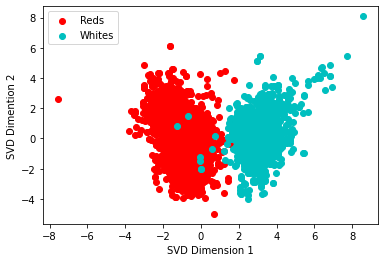

In [44]:
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Reds", "Whites"]

# and we loop over the different groups
for cur_color in [0,1]:
    cur_df = x_train_2d[x_train['red']==cur_color]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_color], label=label_text[cur_color])
    
# all plots need labels
plt.xlabel("SVD Dimension 1")
plt.ylabel("SVD Dimention 2")
plt.legend()

As with PCA, we also want to take a look at the `explained_variance_ratio_` attribute of the SVD object.

In [45]:
var_explained = svd_transformer.explained_variance_ratio_
print("Variance explained by each SVD component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

Variance explained by each SVD component: [0.31657619 0.21142542]
Total Variance Explained: 0.5280016077339864


In this instance, using only 2 dimensions, SVD returns results that are very similar to PCA. The real difference between the two dimensionality reduction techniques would be seen in situations where the data is more sparse. 